# COS 598 Image Processing Spring 2022 HW2 Gaussian Blur in SimpleITK

### By: Nicholas Soucy

## Imports

In [243]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from skimage.filters import gaussian
from skimage.segmentation import active_contour, inverse_gaussian_gradient, morphological_chan_vese
import cv2
%matplotlib inline


print(sitk.Version())

SimpleITK Version: 2.1.1 (ITK 5.2)
Compiled: Sep  8 2021 19:40:35



## Question 1: Linear Filtering

#### Setup Background Image and Image Functions 

Create normalization function for SimpleITK images

In [2]:
def normalize(img):
    max_value = 0
    for x in range(256):
        for y in range(256):
            if img[x,y] > max_value:
                max_value = img[x,y]
    for x in range(256):
        for y in range(256):
            img[x,y] = img[x,y]/max_value
    return img

Show Mona Lisa Background Image without Gaussian Blur

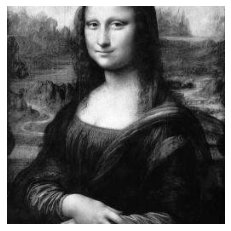

In [3]:
# Retrieve an image from the network, read it and display using the external viewer
mona_itk = sitk.ReadImage('mona_gray.jpeg', sitk.sitkFloat64)
mona_itk = normalize(mona_itk)


plt.imshow(sitk.GetArrayViewFromImage(mona_itk), cmap=plt.cm.Greys_r)
plt.axis('off');

#### Define Guassian Function 

Define Gaussian function to calcuate the guassian and apply it to background

In [4]:
def Cal_Gaussian(a,b,sig_x,sig_y,x_0,y_0,theta):
    #define gaussian image with background
    row,col=b.GetWidth(),b.GetHeight()
    gauss=sitk.Image((row, col), sitk.sitkFloat64)
    
    #define all matrices for gaussian calculation
    epsilon = np.array([[sig_x**2, 0], [0,sig_y**2]])
    epsilon_invert = np.linalg.inv(epsilon)
    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta),np.cos(theta)]])
    mu = np.array([x_0,y_0])
    
    #calculate gaussian for each pixel and apply to each pixel in background
    for x in range(row):
        for y in range(col):
            x_bar = np.array([x,y])
            
            frac = (1.0/(2.0*np.pi*np.sqrt(np.linalg.det(epsilon))))
            
            expo = np.exp(-(((x_bar-mu) @ R @ np.linalg.inv(epsilon) @ R.T @ (x_bar-mu).T)/2.0))
            
            gauss[x,y] = (a * (frac * expo)) + b[x,y]

    
    #renormalize the new picture for relative contrast
    gauss = normalize(gauss)
    return(gauss)

#### Image with Gaussian Spot without Derivative

For this specific implimentation, a = 7000, b = mona list, sig_x = 20, sig_y = 20, x_0 = 128, y_0 = 128, and theta = 0.

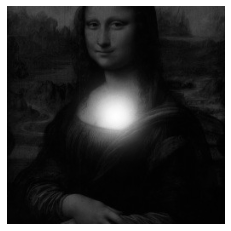

In [5]:
gau = Cal_Gaussian(7000,mona_itk,20,20,128,128,0)
plt.imshow(sitk.GetArrayViewFromImage(gau), cmap=plt.cm.Greys_r)
plt.axis('off');

### A) Continuous Version 

#### Define Guassian Derivative Function

For this function, we have an isotropic gaussian so sig_x = sig_y, we will be using the same gaussian function as before with the added x derivative term. 

In [239]:
def Cal_Gaussian_Der(a,b,sig_x,sig_y,x_0,y_0,theta):
    #define gaussian image with background
    row,col=b.GetWidth(),b.GetHeight()
    gauss=sitk.Image((row, col), sitk.sitkFloat64)
    
    #define all matrices for gaussian calculation
    epsilon = np.array([[sig_x**2, 0], [0,sig_y**2]])
    epsilon_invert = np.linalg.inv(epsilon)
    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta),np.cos(theta)]])
    mu = np.array([x_0,y_0])
    
    #calculate gaussian for each pixel and apply to each pixel in background
    for x in range(row):
        for y in range(col):
            x_bar = np.array([x,y])
            
            frac = (1.0/(2.0*np.pi*np.sqrt(np.linalg.det(epsilon))))
            
            x_der_term = (x_0-x)/(sig_x**2)
            
            expo = np.exp(-(((x_bar-mu) @ R @ np.linalg.inv(epsilon) @ R.T @ (x_bar-mu).T)/2.0))
            
            gauss[x,y] = (a * (x_der_term * frac * expo)) + b[x,y]

    
    #renormalize the new picture for relative contrast
    gauss = normalize(gauss)
    return(gauss)

We still use x_0 = y_0 = 128 and sig = 20.

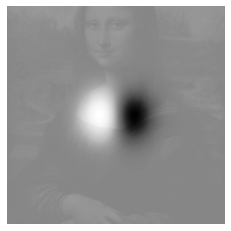

In [240]:
gau_div_cont = Cal_Gaussian_Der(500000,mona_itk,20,20,128,128,0)
plt.imshow(sitk.GetArrayViewFromImage(gau_div_cont), cmap=plt.cm.Greys_r)
plt.axis('off');

### B) Discrete Version 

#### B1) Generate Gaussian Image 

Here we can use the same image as above: 

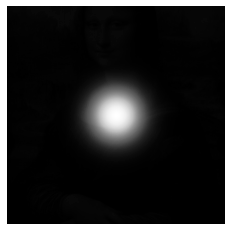

In [161]:
gau = Cal_Gaussian(70000,mona_itk,20,20,128,128,0)
plt.imshow(sitk.GetArrayViewFromImage(gau), cmap=plt.cm.Greys_r)
plt.axis('off');

#### B2) Convolve 3x3 Derivative Filter on the Generated Gaussian Image 

In [237]:
def convolve_sobel(image):
    #First we need to pad the image
    row,col = image.GetWidth()+1,image.GetHeight()+1
    padded = sitk.Image((row, col), sitk.sitkFloat64)
    #Now copy the previous image keeping the padded zeros on the outside
    for x in range(1,image.GetWidth()):
        for y in range(1,image.GetHeight()):
            padded[x,y] = image[x,y] 
    #Now that the image is sucessfully padded with zeros, we can apply the filter.
    row,col = padded.GetWidth(),padded.GetHeight()
    conv = sitk.Image((row, col), sitk.sitkFloat64)
    for x in range(1,image.GetWidth()):
        for y in range(1,image.GetHeight()):
            conv[x,y] = (1.0/6.0)*((-1.0*padded[x-1,y-1])+(-2.0*padded[x-1,y])+(-1.0*padded[x-1,y+1])+(1.0*padded[x+1,y-1])+(2.0*padded[x+1,y])+(1.0*padded[x+1,y+1]))
    #Now lets remove the padding from the image
    final = sitk.Image((image.GetWidth(), image.GetHeight()), sitk.sitkFloat64)
    for x in range(1,image.GetWidth()-1):
        for y in range(1,image.GetHeight()-1):
            final[x,y] = conv[x,y]
    final = normalize(final)
    return(final)
    

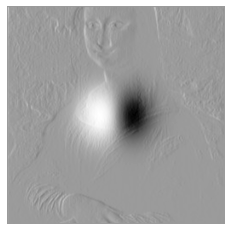

In [238]:
gau_div_des = convolve_sobel(gau)
plt.imshow(sitk.GetArrayViewFromImage(gau_div_des), cmap=plt.cm.Greys_r)
plt.axis('off');

### C) Subtract the Continuous and Descrete Images and Compare Results 

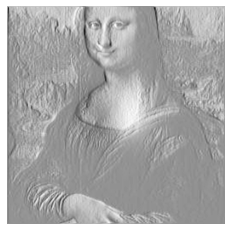

In [241]:
final_sub = sitk.Image((gau_div_des.GetWidth(), gau_div_des.GetHeight()), sitk.sitkFloat64)
for x in range(gau_div_des.GetWidth()):
    for y in range(gau_div_des.GetHeight()):
        final_sub[x,y] = gau_div_cont[x,y] - gau_div_des[x,y]
final_sub = normalize(final_sub)
plt.imshow(sitk.GetArrayViewFromImage(final_sub), cmap=plt.cm.Greys_r)
plt.axis('off');

We can see that when we subtract the two images, we end up with the original mona lisa background image with sharper edges along the x-direction. This is left over from the convolving the sobel kernal along the image instead of calculating the gaussian function continuously. 

Sobel kernals are a popular edge detection algorithm. Once we only used the x-direction kernals, this makes sense that we are left with an x-direction edge detection. In the continous version, we do not get these edges because the edges are an artifact of estimating the derivative of a gaussian along descrete areas of the image. 

## Question 2: Removal of Unwanted Signal

Lets start by loading the images.

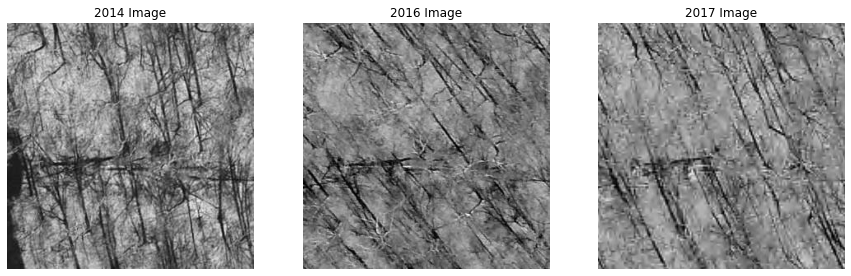

In [348]:
#Load first image 
im1 = cv2.imread('39-53_2014.jpg', cv2.IMREAD_GRAYSCALE) 

#Load second image
im2 = cv2.imread('39-53_2016.jpg', cv2.IMREAD_GRAYSCALE) 

#Load third image
im3 = cv2.imread('39-53_2017.jpg', cv2.IMREAD_GRAYSCALE) 

#Show all images
f, axarr = plt.subplots(1,3,figsize=(15,15))
axarr[0].imshow(im1, cmap='gray')
axarr[0].set_title("2014 Image")
axarr[0].axis('off')
axarr[1].imshow(im2, cmap='gray')
axarr[1].set_title("2016 Image")
axarr[1].axis('off')
axarr[2].imshow(im3, cmap='gray')
axarr[2].set_title("2017 Image")
axarr[2].axis('off')
plt.show()


Now we can do a binary threshold of the images to try and get the dark parts extracted from the image.

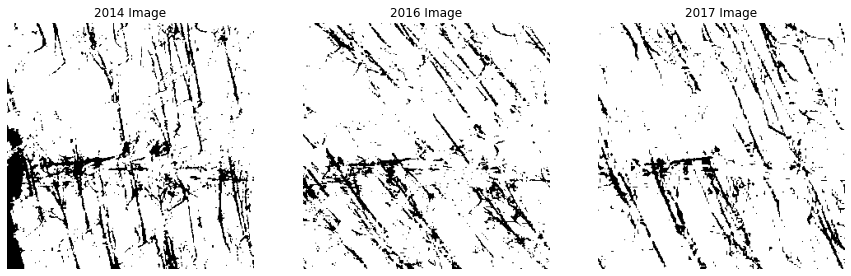

In [373]:
(thresh, im1_thresh) = cv2.threshold(im1, 55, 255, cv2.THRESH_BINARY)
(thresh, im2_thresh) = cv2.threshold(im2, 75, 255, cv2.THRESH_BINARY)
(thresh, im3_thresh) = cv2.threshold(im3, 85, 255, cv2.THRESH_BINARY)


#Show all images
f, axarr = plt.subplots(1,3,figsize=(15,15))
axarr[0].imshow(im1_thresh, cmap='gray')
axarr[0].set_title("2014 Image")
axarr[0].axis('off')
axarr[1].imshow(im2_thresh, cmap='gray')
axarr[1].set_title("2016 Image")
axarr[1].axis('off')
axarr[2].imshow(im3_thresh, cmap='gray')
axarr[2].set_title("2017 Image")
axarr[2].axis('off')
plt.show()

Once these shadows can be categorized as rectangles, we want some form of rectangular bias, therefore, we can use a rectangle kernel in our morphological opening operation.

In addition, once all the shadows are mostly veritcal in each image, we can introduce a vertical bias in our kernal by creating a true rectangle kernal and not a regular square. This can help to keep dark signal that are not shadows, like fallen trees.

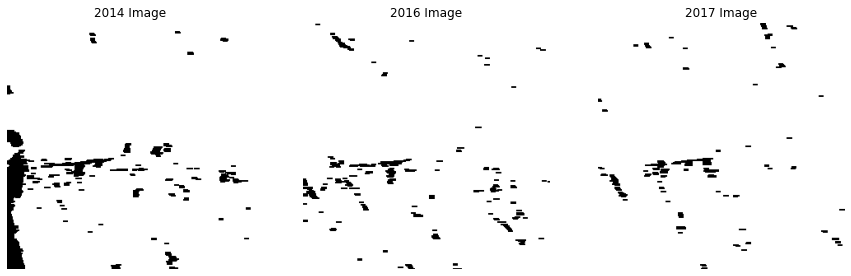

In [381]:
#Retangle kernal with vertical bias
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(6,2))

#Now we can perform opening on the images

#im1
dilated_im1 = cv2.dilate(im1_thresh, kernel, iterations=1)
opened_im1 = cv2.erode(dilated_im1, kernel, iterations=1)

#im2
dilated_im2 = cv2.dilate(im2_thresh, kernel, iterations=1)
opened_im2 = cv2.erode(dilated_im2, kernel, iterations=1)

#im1
dilated_im3 = cv2.dilate(im3_thresh, kernel, iterations=1)
opened_im3 = cv2.erode(dilated_im3, kernel, iterations=1)


#Show all images
f, axarr = plt.subplots(1,3,figsize=(15,15))
axarr[0].imshow(opened_im1, cmap='gray')
axarr[0].set_title("2014 Image")
axarr[0].axis('off')
axarr[1].imshow(opened_im2, cmap='gray')
axarr[1].set_title("2016 Image")
axarr[1].axis('off')
axarr[2].imshow(opened_im3, cmap='gray')
axarr[2].set_title("2017 Image")
axarr[2].axis('off')
plt.show()


As you can see in the image above, we essentially creted a horzontal darkness detector. We want to keep those because those are often fallen trees.

Now once we have a rough apporximation of the darkened signals we wish to keep, we can go ahead and take the difference between the opened images and the original binary thresholded image.

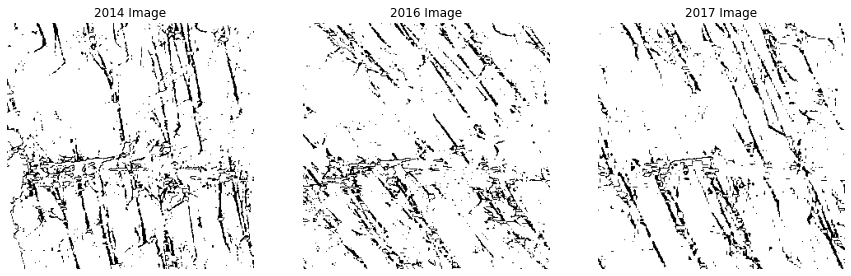

In [382]:
diff_im1 = 255 - cv2.absdiff(im1_thresh, opened_im1)
diff_im2 = 255 - cv2.absdiff(im2_thresh, opened_im2)
diff_im3 = 255 - cv2.absdiff(im3_thresh, opened_im3)

#Show all images
f, axarr = plt.subplots(1,3,figsize=(15,15))
axarr[0].imshow(diff_im1, cmap='gray')
axarr[0].set_title("2014 Image")
axarr[0].axis('off')
axarr[1].imshow(diff_im2, cmap='gray')
axarr[1].set_title("2016 Image")
axarr[1].axis('off')
axarr[2].imshow(diff_im3, cmap='gray')
axarr[2].set_title("2017 Image")
axarr[2].axis('off')
plt.show()

Now we have removed possible fallen trees from the image and we can now invert the image to create a mask.

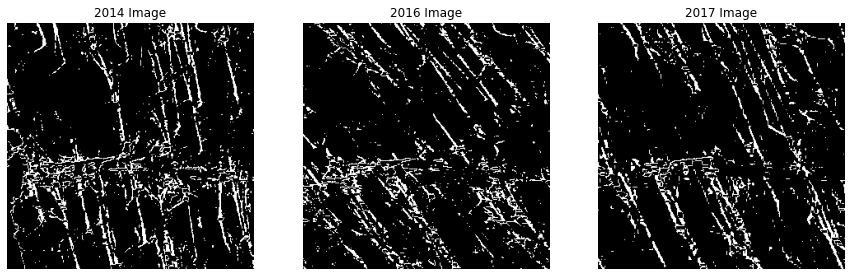

In [383]:
(thresh, diff_im1_thresh) = cv2.threshold(diff_im1, 50, 255, cv2.THRESH_BINARY_INV)
(thresh, diff_im2_thresh) = cv2.threshold(diff_im2, 40, 255, cv2.THRESH_BINARY_INV)
(thresh, diff_im3_thresh) = cv2.threshold(diff_im3, 40, 255, cv2.THRESH_BINARY_INV)


#Show all images
f, axarr = plt.subplots(1,3,figsize=(15,15))
axarr[0].imshow(diff_im1_thresh, cmap='gray')
axarr[0].set_title("2014 Image")
axarr[0].axis('off')
axarr[1].imshow(diff_im2_thresh, cmap='gray')
axarr[1].set_title("2016 Image")
axarr[1].axis('off')
axarr[2].imshow(diff_im3_thresh, cmap='gray')
axarr[2].set_title("2017 Image")
axarr[2].axis('off')
plt.show()

We then use these images we created in the inpaint function as a mask on the original images to help remove the intensity of the shadows in the original image.

Original Images


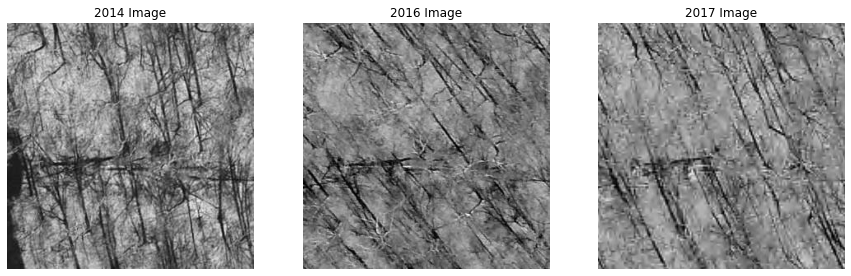

Fixed Images


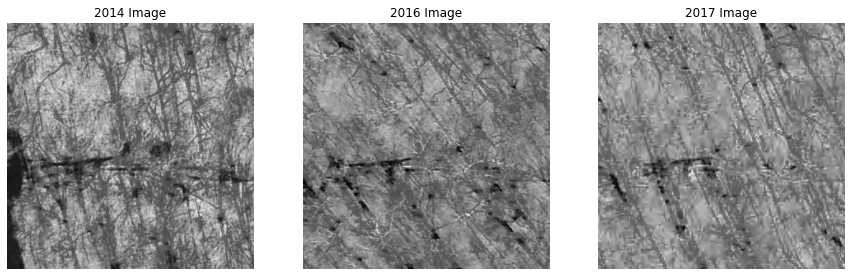

In [384]:
new_im1 = cv2.inpaint(im1,diff_im1_thresh,3,cv2.INPAINT_NS)
new_im2 = cv2.inpaint(im2,diff_im2_thresh,3,cv2.INPAINT_NS)
new_im3 = cv2.inpaint(im3,diff_im3_thresh,3,cv2.INPAINT_NS)

print("Original Images")
#Show all images
f, axarr = plt.subplots(1,3,figsize=(15,15))
axarr[0].imshow(im1, cmap='gray')
axarr[0].set_title("2014 Image")
axarr[0].axis('off')
axarr[1].imshow(im2, cmap='gray')
axarr[1].set_title("2016 Image")
axarr[1].axis('off')
axarr[2].imshow(im3, cmap='gray')
axarr[2].set_title("2017 Image")
axarr[2].axis('off')
plt.show()
print("Fixed Images")
#Show all images
f, axarr = plt.subplots(1,3,figsize=(15,15))
axarr[0].imshow(new_im1, cmap='gray')
axarr[0].set_title("2014 Image")
axarr[0].axis('off')
axarr[1].imshow(new_im2, cmap='gray')
axarr[1].set_title("2016 Image")
axarr[1].axis('off')
axarr[2].imshow(new_im3, cmap='gray')
axarr[2].set_title("2017 Image")
axarr[2].axis('off')
plt.show()

As you can see, the shadows have become quite lighter than the original image all while keeping the darkened signal in the horizontal direction. Therefore we can call this question done!

However, for a little bonus, we can go further and show just the fallen trees, by thresholding out final images.

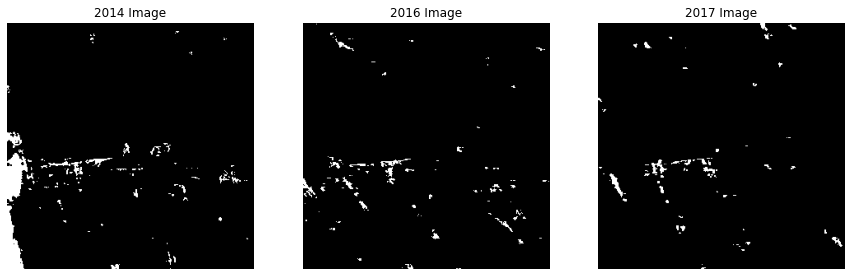

In [388]:
(thresh, new_im1_thresh) = cv2.threshold(new_im1, 40, 255, cv2.THRESH_BINARY_INV)
(thresh, new_im2_thresh) = cv2.threshold(new_im2, 45, 255, cv2.THRESH_BINARY_INV)
(thresh, new_im3_thresh) = cv2.threshold(new_im3, 60, 255, cv2.THRESH_BINARY_INV)


#Show all images
f, axarr = plt.subplots(1,3,figsize=(15,15))
axarr[0].imshow(new_im1_thresh, cmap='gray')
axarr[0].set_title("2014 Image")
axarr[0].axis('off')
axarr[1].imshow(new_im2_thresh, cmap='gray')
axarr[1].set_title("2016 Image")
axarr[1].axis('off')
axarr[2].imshow(new_im3_thresh, cmap='gray')
axarr[2].set_title("2017 Image")
axarr[2].axis('off')
plt.show()

In general this is a pretty difficult problem. So this is the closest I could get! More analysis can be done by closely tinkering with the parameters throughout this pipline.

## Question 3: Basic Segmentation Methods

Lets start by displaying both of our images.

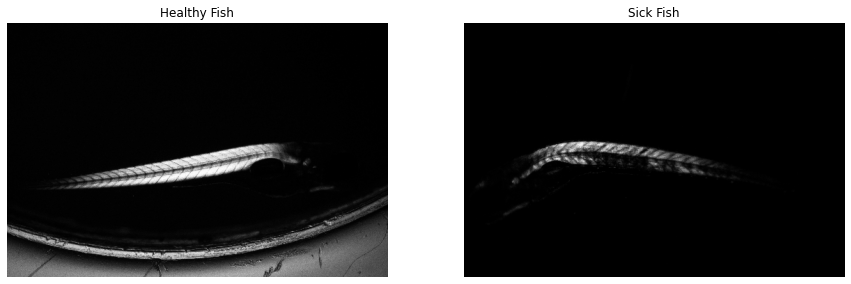

In [125]:
#Load first image 
healthy_fish_bf = cv2.imread('AA9_sib_e41_6dpf_bire.png', cv2.IMREAD_GRAYSCALE)
#Reduce size of image for better running time
healthy_fish_bf = cv2.resize(healthy_fish_bf, None, fx=0.1, fy=0.1, interpolation = cv2.INTER_CUBIC)

#Load second image
sick_fish_bf = cv2.imread('AA9_mut_e13_6dpf_bire.png', cv2.IMREAD_GRAYSCALE) 
#Reduce size of image for better running time
sick_fish_bf = cv2.resize(sick_fish_bf, None, fx=0.1, fy=0.1, interpolation = cv2.INTER_CUBIC)


#Show all images
f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(healthy_fish_bf, cmap='gray')
axarr[0].set_title("Healthy Fish")
axarr[0].axis('off')
axarr[1].imshow(sick_fish_bf, cmap='gray')
axarr[1].set_title("Sick Fish")
axarr[1].axis('off')
plt.show()



There is a weird lens visable in the healthy fish that will mess up our thresholding, so lets remove it. Once we are at it, we can resize the sick fish as well so they are both the same size.

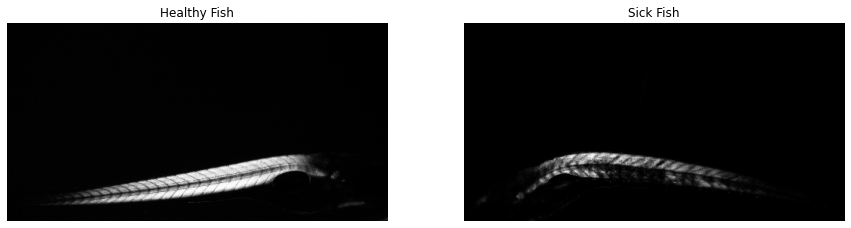

In [126]:
#Crop healthy fish image
healthy_fish_bf_crop = healthy_fish_bf[:260, :500]
sick_fish_bf_crop = sick_fish_bf[:260, :500]

#Show all images
f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(healthy_fish_bf_crop, cmap='gray')
axarr[0].set_title("Healthy Fish")
axarr[0].axis('off')
axarr[1].imshow(sick_fish_bf_crop, cmap='gray')
axarr[1].set_title("Sick Fish")
axarr[1].axis('off')
plt.show()



### Method 1: Thresholding, Mathematical Morphology, & Contours

Then we can threshold both images using binary thresholding with the Otsu threshold method. This way we can intensify our edges/features.

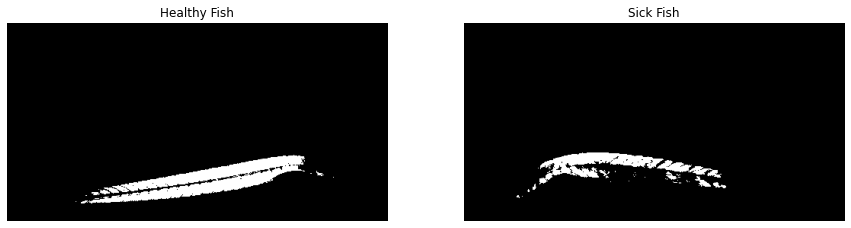

In [127]:
(thresh, healthy_fish_bf_thresh) = cv2.threshold(healthy_fish_bf_crop, 110, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
(thresh, sick_fish_bf_thresh) = cv2.threshold(sick_fish_bf_crop, 110, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


#Show all images
f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(healthy_fish_bf_thresh, cmap='gray')
axarr[0].set_title("Healthy Fish")
axarr[0].axis('off')
axarr[1].imshow(sick_fish_bf_thresh, cmap='gray')
axarr[1].set_title("Sick Fish")
axarr[1].axis('off')
plt.show()

Now we can perform dilation from mathematical morphology to fully define the edges of the structure.

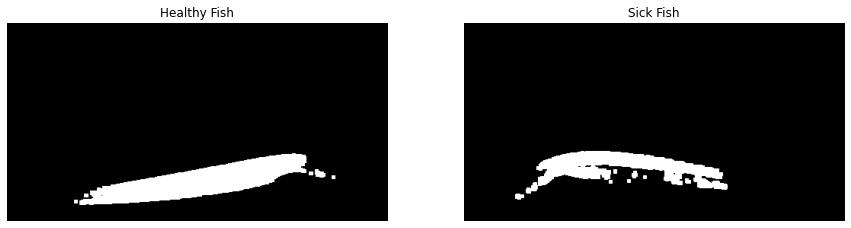

In [128]:
#Using both ellipse and rectangle kernals helps pervent bias that arise from a kernal of a particular shape. 
#This method is used by Joseph Patton, Mac Creamer, and I in our class project as well!

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
healthy_fish_bf_thresh_di = cv2.dilate(healthy_fish_bf_thresh,kernel,iterations = 1)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
healthy_fish_bf_thresh_di = cv2.dilate(healthy_fish_bf_thresh,kernel,iterations = 1)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
sick_fish_bf_thresh_di = cv2.dilate(sick_fish_bf_thresh,kernel,iterations = 1)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
sick_fish_bf_thresh_di = cv2.dilate(sick_fish_bf_thresh,kernel,iterations = 1)

#Show all images
f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(healthy_fish_bf_thresh_di, cmap='gray')
axarr[0].set_title("Healthy Fish")
axarr[0].axis('off')
axarr[1].imshow(sick_fish_bf_thresh_di, cmap='gray')
axarr[1].set_title("Sick Fish")
axarr[1].axis('off')
plt.show()



Now using the dilated images we can calculate and display the brightness contours over the originial images. The contours are drawn in using bright white.

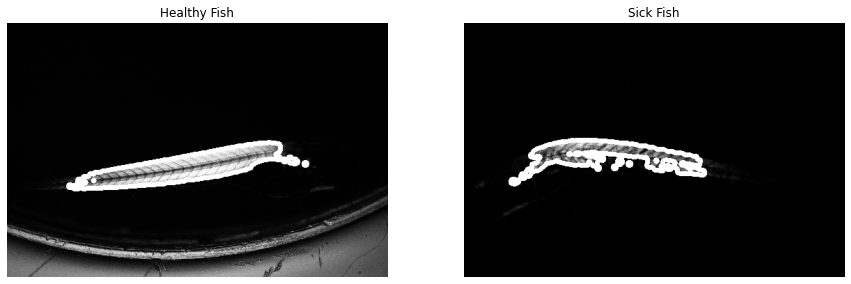

In [175]:
# calculate contours
# ret,thresh = cv2.threshold(sick_fish_bf_thresh_di, 100,255,cv2.THRESH_BINARY)
contours_healthy = cv2.findContours(healthy_fish_bf_thresh_di,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)[-2]
contours_sick = cv2.findContours(sick_fish_bf_thresh_di,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)[-2]

#Create copies so we don't draw on the original image
healthy_fish_bf_copy = healthy_fish_bf.copy()
sick_fish_bf_copy = sick_fish_bf.copy()

# plot contour on original image
for contour in contours_healthy:
    cv2.drawContours(healthy_fish_bf_copy, contour, -1, (255, 255, 255), 5)

# plot contour on original image
for contour in contours_sick:
    cv2.drawContours(sick_fish_bf_copy, contour, -1, (255, 255, 255), 5)
    
#Show all images
f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(healthy_fish_bf_copy, cmap='gray')
axarr[0].set_title("Healthy Fish")
axarr[0].axis('off')
axarr[1].imshow(sick_fish_bf_copy, cmap='gray')
axarr[1].set_title("Sick Fish")
axarr[1].axis('off')
plt.show()

### Method 2: Active Contours

Here we can start with the tresholded images that we have performed dilation on to help define edges.

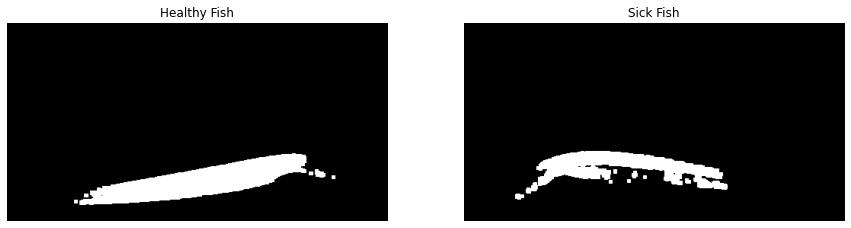

In [132]:
#Using both ellipse and rectangle kernals helps pervent bias that arise from a kernal of a particular shape. 
#This method is used by Joseph Patton, Mac Creamer, and I in our class project as well!

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
healthy_fish_bf_thresh_di = cv2.dilate(healthy_fish_bf_thresh,kernel,iterations = 1)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
healthy_fish_bf_thresh_di = cv2.dilate(healthy_fish_bf_thresh,kernel,iterations = 1)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
sick_fish_bf_thresh_di = cv2.dilate(sick_fish_bf_thresh,kernel,iterations = 1)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
sick_fish_bf_thresh_di = cv2.dilate(sick_fish_bf_thresh,kernel,iterations = 1)

#Show all images
f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(healthy_fish_bf_thresh_di, cmap='gray')
axarr[0].set_title("Healthy Fish")
axarr[0].axis('off')
axarr[1].imshow(sick_fish_bf_thresh_di, cmap='gray')
axarr[1].set_title("Sick Fish")
axarr[1].axis('off')
plt.show()

Then we can start to draw the initial snake on our image that we will define as a circle on each image.

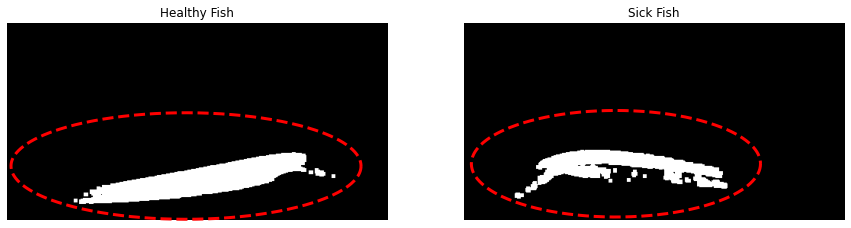

In [158]:
#Initial snake for healthy fish
s_h = np.linspace(0, 2*np.pi, 400)
r_h = 188 + 70*np.sin(s_h)
c_h = 235 + 230*np.cos(s_h)
init_health = np.array([r_h, c_h]).T

#Initial snake for sick fish
s_s = np.linspace(0, 2*np.pi, 400)
r_s = 185 + 70*np.sin(s_s)
c_s = 200 + 190*np.cos(s_s)
init_sick = np.array([r_s, c_s]).T


#Plot with snake
fig, ax = plt.subplots(1,2,figsize=(15, 15))
ax[0].set_title("Healthy Fish")
ax[0].imshow(healthy_fish_bf_thresh_di, cmap=plt.cm.gray)
ax[0].plot(init_health[:, 1], init_health[:, 0], '--r', lw=3)
ax[0].axis('off')
ax[0].axis([0, healthy_fish_bf_thresh_di.shape[1], healthy_fish_bf_thresh_di.shape[0], 0])
ax[1].set_title("Sick Fish")
ax[1].imshow(sick_fish_bf_thresh_di, cmap=plt.cm.gray)
ax[1].plot(init_sick[:, 1], init_sick[:, 0], '--r', lw=3)
ax[1].axis('off')
ax[1].axis([0, sick_fish_bf_thresh_di.shape[1], sick_fish_bf_thresh_di.shape[0], 0])
plt.show()


Calculate active contour snakes.

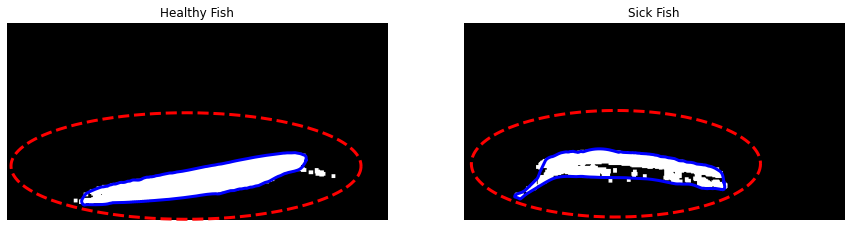

In [256]:
snake_healthy = active_contour(gaussian(healthy_fish_bf_thresh_di, 3, preserve_range=False),
                       init, alpha = 0.015, beta=10, gamma=0.001) #original alpha = 0.015, beta=10, gamma=0.001


snake_sick = active_contour(gaussian(sick_fish_bf_thresh_di, 3, preserve_range=False),
                       init, alpha = 0.015, beta=10, gamma=0.001) #original alpha = 0.015, beta=10, gamma=0.001

#Plot with snake
fig, ax = plt.subplots(1,2,figsize=(15, 15))
ax[0].set_title("Healthy Fish")
ax[0].imshow(healthy_fish_bf_thresh_di, cmap=plt.cm.gray)
ax[0].plot(init_health[:, 1], init_health[:, 0], '--r', lw=3)
ax[0].plot(snake_healthy[:, 1], snake_healthy[:, 0], '-b', lw=3)
ax[0].axis('off')
ax[0].axis([0, healthy_fish_bf_thresh_di.shape[1], healthy_fish_bf_thresh_di.shape[0], 0])
ax[1].set_title("Sick Fish")
ax[1].imshow(sick_fish_bf_thresh_di, cmap=plt.cm.gray)
ax[1].plot(init_sick[:, 1], init_sick[:, 0], '--r', lw=3)
ax[1].plot(snake_sick[:, 1], snake_sick[:, 0], '-b', lw=3)
ax[1].axis('off')
ax[1].axis([0, sick_fish_bf_thresh_di.shape[1], sick_fish_bf_thresh_di.shape[0], 0])
plt.show()

### Discussion of Both Methods

It appears that the active contour method performed slightly worse than our combination method. Method 2 needs a lot of parameters and therefore requires tunning while the Method 1 is more trustworthy and straight forward.

Method 2 does not seem to capture the small structures of the fish that Method 1 captures easily. Therefore I determine Method 1 to be a better and trustworthy method. 